# Attention Visualization for BERT on SQuAD
Abhimanyu Talwar

* **What is this?** This self-contained notebook visualizes attention of a Question over Context (the paragraph which possibly contains the answer to the question)

* **Credits**: Huge shoutout to [Hugging Face](https://github.com/huggingface/pytorch-transformers). I used their BERT implementation along with their code for training.

* **My Contribution**: I finetuned Hugging Face's BERT on the SQuAD 2.0 Training Set. I wrote the code for extracting activations, and computing/visualizing attention weights.


You can see more of my NLP experiments [here](https://github.com/talwarabhimanyu/nlp_experiments).

**UPDATES**

* **30-July-2019**: Updated notebook to use Hugging Face's pytorch-transformers package, from pytorch-pretrained-bert earlier.

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

import math

import sys
import time

import numpy as np
import pandas as pd
import json
import collections
import logging
from scipy.special import softmax
import seaborn as sns
import matplotlib.pyplot as plt


pd.options.display.float_format = '{:.3f}'.format

%%bash
pip install tensorboardX
pip install pytorch-transformers

In [3]:
from transformers import BertForQuestionAnswering, BasicTokenizer, BertTokenizer

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import Hugging-Face's Script for Evaluating BERT on SQuAD
I'm creating a package called 'hugging-face-squad' locally which contains Hugging Face's 'run_squad' script and its dependencies, which I will use for evaluting queries.

<a href="https://github.com/huggingface/pytorch-transformers/blob/master/examples/run_squad.py">Github link to the script</a>

In [6]:
import run_squad, utils_squad

import importlib
hfs = importlib.import_module('.run_squad', package='hugging-face-squad')

# Download Dataset

%%bash
wget -q 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'
wget -q 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json'

## Store Dataset in a DataFrame and Print Some Samples

In [7]:
with open('SQUAD/dev-v2.0.json', 'r') as f:
    valid_data = json.load(f)['data']
print('Number of validation datapoints is ', len(valid_data))

Number of validation datapoints is  35


In [8]:
with open('SQUAD/train-v2.0.json', 'r') as f:
    train_data = json.load(f)['data']
print('Number of training datapoints is ', len(train_data))

Number of training datapoints is  442


In [9]:
def PrettyPrintSentence(sentence_, size_=15):
    word_list_ = sentence_.split()
    chunks_ = [' '.join(word_list_[x:x+size_]) for x \
               in range(0, len(word_list_), size_)]
    for c in chunks_:
        print(c) 
        
def PrettyPrintQA(qa_list):
    print('Question', ' '*90, 'Answer')
    for qdict in qa_list:
        ques_ = qdict['question']
        is_impossible = qdict['is_impossible']
        if not is_impossible:
            ans_ = qdict['answers'][0]['text']
        else:
            ans_ = '[PLAUSIBLE] ' + qdict['plausible_answers'][0]['text']
        print(ques_ + ' '*(100-len(ques_)) + ans_)

def PrintAttributeNames(obj_):
    attrs_ = dir(obj_)
    print('The attributes of object {} are:'.format(str(type(obj_)).\
                            replace('<class \'', '').replace('\'>', '')))
    for attr_ in attrs_:
        if '__' not in attr_:
            print(attr_)

In [10]:
idx_ = 1
sample_ = train_data[idx_]['paragraphs']
print(len(sample_))
print('Example from the Training Set')

print('='*120)
print('CONTEXT: ')
print('='*120)
PrettyPrintSentence(sample_[1]['context'])
print('='*120)
print('Q&A: ')
print('='*120)
PrettyPrintQA(sample_[1]['qas'])

82
Example from the Training Set
CONTEXT: 
At the age of 21 he settled in Paris. Thereafter, during the last 18 years
of his life, he gave only some 30 public performances, preferring the more intimate atmosphere
of the salon. He supported himself by selling his compositions and teaching piano, for which
he was in high demand. Chopin formed a friendship with Franz Liszt and was admired
by many of his musical contemporaries, including Robert Schumann. In 1835 he obtained French citizenship.
After a failed engagement to Maria Wodzińska, from 1837 to 1847 he maintained an often
troubled relationship with the French writer George Sand. A brief and unhappy visit to Majorca
with Sand in 1838–39 was one of his most productive periods of composition. In his
last years, he was financially supported by his admirer Jane Stirling, who also arranged for
him to visit Scotland in 1848. Through most of his life, Chopin suffered from poor
health. He died in Paris in 1849, probably of tuberculosis.
Q&A:

In [11]:
idx_ = 0
sample_ = valid_data[idx_]['paragraphs']
print('Example from the Validation Set')

print('='*120)
print('CONTEXT: ')
print('='*120)
PrettyPrintSentence(sample_[0]['context'])
print('='*120)
print('Q&A: ')
print('='*120)
PrettyPrintQA(sample_[0]['qas'])

Example from the Validation Set
CONTEXT: 
The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th
and 11th centuries gave their name to Normandy, a region in France. They were descended
from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who,
under their leader Rollo, agreed to swear fealty to King Charles III of West Francia.
Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants
would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic
identity of the Normans emerged initially in the first half of the 10th century, and
it continued to evolve over the succeeding centuries.
Q&A: 
Question                                                                                            Answer
In what country is Normandy located?                                                                Fr

# Data Preprocessing and Loading

In [12]:
BERT_TYPE = 'bert-base-uncased'
LOWER_CASE = True
PREDICT_BATCH_SIZE = 1
TRAIN_BATCH_SIZE = 8
MAX_SEQ_LEN = 384
DOC_STRIDE = 128
MAX_QUERY_LEN = 64

MAX_ANS_LEN = 30
N_BEST_SIZE = 20
NULL_SCORE_THRESHOLD = 0.0

### Below, valid_examples is a list of SquadExample objects.

In [13]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)

In [14]:

valid_examples = read_squad_examples(input_file='SQUAD/dev-v2.0.json', \
                                         is_training=False, version_2_with_negative=True)

In [15]:
print(len(valid_examples), valid_examples[0])

11873 qas_id: 56ddde6b9a695914005b9628, question_text: In what country is Normandy located?, doc_tokens: [The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.]


### The SquadExample object
Each instance of SquadExample represents one question. Its attributes are:
* doc_tokens is a list of tokens appearing in a Context string.
* question_text contains a single string which represents a question.
* qas_id
* other attributes are empty for Validation Set.

In [16]:
PrintAttributeNames(valid_examples[0])

The attributes of object utils_squad.SquadExample are:
doc_tokens
end_position
is_impossible
orig_answer_text
qas_id
question_text
start_position


In [17]:
print(valid_examples[0].start_position)

None


In [18]:
tokenizer = BertTokenizer.from_pretrained(BERT_TYPE, do_lower_case=LOWER_CASE)

### The 'tokenizer' object contains two tokenizers
* basic_tokenizer
* wordpiece_tokenizer

In [19]:
PrintAttributeNames(tokenizer)

The attributes of object transformers.tokenization_bert.BertTokenizer are:
SPECIAL_TOKENS_ATTRIBUTES
_additional_special_tokens
_bos_token
_cls_token
_convert_id_to_token
_convert_token_to_id
_convert_token_to_id_with_added_voc
_eos_token
_from_pretrained
_mask_token
_pad_token
_sep_token
_tokenize
_unk_token
add_special_tokens
add_tokens
added_tokens_decoder
added_tokens_encoder
additional_special_tokens
additional_special_tokens_ids
all_special_ids
all_special_tokens
basic_tokenizer
bos_token
bos_token_id
build_inputs_with_special_tokens
clean_up_tokenization
cls_token
cls_token_id
convert_ids_to_tokens
convert_tokens_to_ids
convert_tokens_to_string
create_token_type_ids_from_sequences
decode
do_basic_tokenize
encode
encode_plus
eos_token
eos_token_id
from_pretrained
get_special_tokens_mask
ids_to_tokens
init_inputs
init_kwargs
mask_token
mask_token_id
max_len
max_len_sentences_pair
max_len_single_sentence
max_model_input_sizes
num_added_tokens
pad_token
pad_token_id
prepare_for_mode

In [20]:
PrintAttributeNames(tokenizer.basic_tokenizer)

The attributes of object transformers.tokenization_bert.BasicTokenizer are:
_clean_text
_is_chinese_char
_run_split_on_punc
_run_strip_accents
_tokenize_chinese_chars
do_lower_case
never_split
tokenize
tokenize_chinese_chars


In [21]:
PrintAttributeNames(tokenizer.wordpiece_tokenizer)

The attributes of object transformers.tokenization_bert.WordpieceTokenizer are:
max_input_chars_per_word
tokenize
unk_token
vocab


### Below, valid_features is a list of InputFeatures objects.

In [22]:
valid_features = convert_examples_to_features(
            examples=valid_examples,
            tokenizer=tokenizer,
            max_seq_length=MAX_SEQ_LEN,
            doc_stride=DOC_STRIDE,
            max_query_length=MAX_QUERY_LEN,
            is_training=False)

In [23]:
PrintAttributeNames(valid_features[0])

The attributes of object utils_squad.InputFeatures are:
cls_index
doc_span_index
end_position
example_index
input_ids
input_mask
is_impossible
p_mask
paragraph_len
segment_ids
start_position
token_is_max_context
token_to_orig_map
tokens
unique_id


### Below is a comparison of valid_features and valid_examples
* input_ids: Length is 384, which is a hyperparameter denoting max_sequence_length. All entries in input_ids after the index 166 are zeros and reflect padding.
* input_mask: Length is 384. Equals 1 where input_ids is non-zero. This mask takes care of padding.
* segment_ids: Length is 384. Equals 1 at indices where tokens DOES NOT contain a question or pad token. This mask preserves the context tokens.

At Test time, the inputs to the model are: input_ids, input_mask, segment_ids

In [24]:
print('='*150)
print('valid_examples')
print('='*150)
print('1. doc_tokens', ' '*7, '[Length: {}]'.format(len(valid_examples[0].doc_tokens)))
print(valid_examples[0].doc_tokens)
print('\n2. question_text', ' '*4, '[Length: {}]'.format(len(valid_examples[0].question_text)))
print(valid_examples[0].question_text)

print('\n')
print('='*150)
print('valid_features')
print('='*150)
print('1. tokens', ' '*11, '[Length: {}]'.format(len(valid_features[0].tokens)))
print(valid_features[0].tokens)
print('\n2. input_ids', ' '*8, '[Length: {}]'.format(len(valid_features[0].input_ids)))
print(valid_features[0].input_ids)
print('\n3. input_masks', ' '*8, '[Length: {}]'.format(len(valid_features[0].input_mask)))
print(valid_features[0].input_mask)
print('\n4. segment_ids', ' '*8, '[Length: {}]'.format(len(valid_features[0].segment_ids)))
print(valid_features[0].segment_ids)

valid_examples
1. doc_tokens         [Length: 113]
['The', 'Normans', '(Norman:', 'Nourmands;', 'French:', 'Normands;', 'Latin:', 'Normanni)', 'were', 'the', 'people', 'who', 'in', 'the', '10th', 'and', '11th', 'centuries', 'gave', 'their', 'name', 'to', 'Normandy,', 'a', 'region', 'in', 'France.', 'They', 'were', 'descended', 'from', 'Norse', '("Norman"', 'comes', 'from', '"Norseman")', 'raiders', 'and', 'pirates', 'from', 'Denmark,', 'Iceland', 'and', 'Norway', 'who,', 'under', 'their', 'leader', 'Rollo,', 'agreed', 'to', 'swear', 'fealty', 'to', 'King', 'Charles', 'III', 'of', 'West', 'Francia.', 'Through', 'generations', 'of', 'assimilation', 'and', 'mixing', 'with', 'the', 'native', 'Frankish', 'and', 'Roman-Gaulish', 'populations,', 'their', 'descendants', 'would', 'gradually', 'merge', 'with', 'the', 'Carolingian-based', 'cultures', 'of', 'West', 'Francia.', 'The', 'distinct', 'cultural', 'and', 'ethnic', 'identity', 'of', 'the', 'Normans', 'emerged', 'initially', 'in', 'the', '

# Model Setup


## Download BERT model weights finetuned for SQuAD by me
### DISCLAIMER: Use at your own risk
I will not be held responsbile for any loss of any sort occuring to you from use of these finetuned weights.
Link to SQUAD pretrained -  https://drive.google.com/uc?id=1nDs0_agVNDsn5X_b0QCKNQVIQ-aGBFzY

In [25]:
torch.cuda.is_available()

True

In [26]:
model_state_dict = torch.load('SQUAD/checkpoints/pytorch_model.bin')
model = BertForQuestionAnswering.from_pretrained(BERT_TYPE, state_dict=model_state_dict)
model.to(device);

# Evaluation on Validation Set Samples

In [27]:
model.eval();

In [28]:
all_input_ids = torch.tensor([f.input_ids for f in valid_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in valid_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in valid_features], dtype=torch.long)
all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
valid_data_tensor = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_example_index)
# Run prediction for full data
valid_sampler = SequentialSampler(valid_data_tensor)
valid_dataloader = DataLoader(valid_data_tensor, sampler=valid_sampler, batch_size=PREDICT_BATCH_SIZE)


In [33]:
# all_input_ids[0]
all_example_index[3]

tensor(3)

In [35]:
input_ids, input_mask, segment_ids, example_indices = next(iter(valid_dataloader))
input_ids = input_ids.to(device)
input_mask = input_mask.to(device)
segment_ids = segment_ids.to(device)
with torch.no_grad():
    batch_start_logits, batch_end_logits = model(input_ids, segment_ids, input_mask)
    print(batch_start_logits.shape, batch_end_logits.shape)

torch.Size([1, 384]) torch.Size([1, 384])


In [36]:
all_examples = []
all_features = []
all_results = []
for i, example_index in enumerate(example_indices):
    start_logits = batch_start_logits[i].detach().cpu().tolist()
    end_logits = batch_end_logits[i].detach().cpu().tolist()
    valid_feature = valid_features[example_index.item()]
    unique_id = int(valid_feature.unique_id)
    all_results.append(RawResult(unique_id=unique_id,
                                 start_logits=start_logits,
                                 end_logits=end_logits))
    all_examples.append(valid_examples[example_index.item()])
    all_features.append(valid_feature)

In [37]:
print(len(all_results), len(all_features), len(all_examples))

1 1 1


In [38]:
print(all_results)

[RawResult(unique_id=1000000000, start_logits=[-1.7735379934310913, -7.431614398956299, -7.153642654418945, -10.008705139160156, -8.530970573425293, -4.674806118011475, -9.710234642028809, -7.282372951507568, -9.899028778076172, -5.438775539398193, -3.878025770187378, -9.427628517150879, -6.930257797241211, -7.3700480461120605, -9.97557544708252, -6.973975658416748, -10.908218383789062, -11.224370956420898, -9.572864532470703, -9.94036865234375, -8.891755104064941, -9.980629920959473, -8.551385879516602, -9.81502628326416, -10.307576179504395, -9.265114784240723, -10.365907669067383, -7.283215045928955, -9.295825958251953, -8.040661811828613, -7.2629523277282715, -7.917047023773193, -8.372166633605957, -9.186210632324219, -7.553506374359131, -9.152785301208496, -8.66385269165039, -10.356693267822266, -9.96823787689209, -10.51996898651123, -6.644506931304932, -7.8011698722839355, -8.491207122802734, -10.070208549499512, -5.1695356369018555, -8.284402847290039, -9.258186340332031, -9.456

In [40]:
PRED_FILE = 'predictions.json'
N_BEST_FILE = 'nbest.json'
LOG_ODDS_FILE = 'logodds.json'

In [41]:
write_predictions(all_examples=all_examples, 
                      all_features=all_features, 
                      all_results=all_results,
                      n_best_size=N_BEST_SIZE, 
                      max_answer_length=MAX_ANS_LEN,
                      do_lower_case=LOWER_CASE, 
                      output_prediction_file=PRED_FILE,
                      output_nbest_file=N_BEST_FILE, 
                      output_null_log_odds_file=LOG_ODDS_FILE, 
                      verbose_logging=True,
                      version_2_with_negative=True, 
                      null_score_diff_threshold=NULL_SCORE_THRESHOLD)

OrderedDict([('56ddde6b9a695914005b9628', '')])

In [42]:
results_json = pd.read_json('nbest.json')
results_text = [results_json.iloc[i].values[0]['text'] for i in range(len(results_json))]
results_prob = [results_json.iloc[i].values[0]['probability'] for i in range(len(results_json))]
df = pd.DataFrame({'Probability' : results_prob,
                   'Text' : results_text
                  })

In [43]:
df.head()

,Probability,Text
0,0.990,
1,0.004,Normans
2,0.001,Normans (Norman: Nourmands; French: Normands; ...
3,0.001,The Normans
4,0.001,Normandy


# Evaluation on Custom Examples

In [45]:
def GetQuestionDict(context_, question_):
    main_dict = {'title' : 'test-question',
            'paragraphs' : []}
    para_dict = {'context' : context_,
            'qas' : []}
       
    ques_dict = {'answers' : [],
                'id' : i+1,
                'is_impossible' : False,
                'question' : question_}

    para_dict['qas'].append(ques_dict)
    main_dict['paragraphs'].append(para_dict)
    return_dict = {'data' : [main_dict],
                  'version' : 'no-cares'}
    
    return return_dict

def GetFeatures(context_, question_):
    input_ = GetQuestionDict(context_, question_)

    import json
    with open('test.json', 'w') as f:
        json.dump(input_, f)
        
    test_examples = hfs.read_squad_examples(input_file='test.json', \
                   is_training=False, version_2_with_negative=True)
    test_features = hfs.convert_examples_to_features(
            examples=test_examples,
            tokenizer=tokenizer,
            max_seq_length=MAX_SEQ_LEN,
            doc_stride=DOC_STRIDE,
            max_query_length=MAX_QUERY_LEN,
            is_training=False)
    
    return test_examples, test_features

def GetPrediction(model, context_, question_):
    test_examples, test_features = GetFeatures(context_, question_)
    
    all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)
    all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
    test_data_tensor = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_example_index)
    # Run prediction for full data
    test_sampler = SequentialSampler(test_data_tensor)
    test_dataloader = DataLoader(test_data_tensor, sampler=test_sampler, batch_size=PREDICT_BATCH_SIZE)

    input_ids, input_mask, segment_ids, example_indices = next(iter(test_dataloader))
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    with torch.no_grad():
        batch_start_logits, batch_end_logits = model(input_ids, segment_ids, input_mask)
    
    all_examples = []
    all_features = []
    all_results = []
    for i, example_index in enumerate(example_indices):
        start_logits = batch_start_logits[i].detach().cpu().tolist()
        end_logits = batch_end_logits[i].detach().cpu().tolist()
        test_feature = test_features[example_index.item()]
        unique_id = int(test_feature.unique_id)
        all_results.append(hfs.RawResult(unique_id=unique_id,
                                     start_logits=start_logits,
                                     end_logits=end_logits))
        all_examples.append(test_examples[example_index.item()])
        all_features.append(test_feature)
        
    PRED_FILE = 'test-predictions.json'
    N_BEST_FILE = 'test-nbest.json'
    LOG_ODDS_FILE = 'test-logodds.json'

    write_predictions(all_examples=all_examples, 
                          all_features=all_features, 
                          all_results=all_results,
                          n_best_size=N_BEST_SIZE, 
                          max_answer_length=MAX_ANS_LEN,
                          do_lower_case=LOWER_CASE, 
                          output_prediction_file=PRED_FILE,
                          output_nbest_file=N_BEST_FILE, 
                          output_null_log_odds_file=LOG_ODDS_FILE, 
                          verbose_logging=True,
                          version_2_with_negative=True, 
                          null_score_diff_threshold=NULL_SCORE_THRESHOLD)

    results_json = pd.read_json('test-nbest.json')
    results_text = [results_json.iloc[i].values[0]['text'] for i in range(len(results_json))]
    results_prob = [results_json.iloc[i].values[0]['probability'] for i in range(len(results_json))]
    df = pd.DataFrame({'Probability' : results_prob,
                       'Text' : results_text
                      })
    return df

# Visualization

In [46]:
idx_ = 0
context_ = valid_data[idx_]['paragraphs'][0]['context']
PrettyPrintSentence(context_)

The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th
and 11th centuries gave their name to Normandy, a region in France. They were descended
from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who,
under their leader Rollo, agreed to swear fealty to King Charles III of West Francia.
Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants
would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic
identity of the Normans emerged initially in the first half of the 10th century, and
it continued to evolve over the succeeding centuries.


### Note on register_forward_hook
From [PyTorch Docs](https://pytorch.org/docs/stable/nn.html?highlight=register_forward_hook#torch.nn.Module.register_forward_hook), the "hook" is a function that is called everytime "forward()" computes an output. The signature of the "hook" is:

hook(module, input, output) -> None

In [0]:
def GetActivation(model, context_, question_):
    name_list = ['key', 'query']
    NUM_LAYERS = 12
    activation = {i : {name_ : [] for name_ in name_list} \
                  for i in range(NUM_LAYERS)}
    
    def GetHook(layer_, name_):
        def hook(model, input_, output_):
            activation[layer_][name_].append(output_.detach())
        return hook
    for i in range(NUM_LAYERS):
        model.bert.encoder.layer[i].attention.self.key.register_forward_hook(
                                                GetHook(i, 'key'))
        model.bert.encoder.layer[i].attention.self.query.register_forward_hook(
                                                GetHook(i, 'query'))
    df  = GetPrediction(model, context_, question_)
    return df, activation

In [0]:
question_ = 'In what country is Normandy located?'
df, activation = GetActivation(model, context_, question_)

### Note on BERT Architecture
I have used the BERT Base model which has 12 "BERTLayers", and each BERTLayer uses a Multihead Attention module with 12 Attention Heads. For a particular BERTLayer and a particular Attention Head inside it, first the 768 dimensional input embedding needs to be projected into a 64 dimensional subspace - so combining these projection outputs for all  heads, we should get a 768 dimensional combined output (64 dim. input size * 12 attention heads). This projection is carried out in the Hugging Face implementation through a single LinearLayer with input-dim and output-dim of 768.

In [0]:
def PlotAttention(activation, layer_=0, head_=0, num_attn_heads=12):
    # d_k is the dimension of the subspace in which the input embedding is
    # projected before attention calculation.
    d_k = int(activation[layer_]['key'][0].shape[-1]/num_attn_heads)
    
    keys_ = activation[layer_]['key'][0].cpu().numpy()[0,:,head_*d_k:(head_+1)*d_k]
    queries_ = activation[layer_]['query'][0].cpu().numpy()[0,:,head_*d_k:(head_+1)*d_k]
    
    attention_ = softmax(np.matmul(queries_, keys_.T)/np.sqrt(d_k), axis=1)
    examples_, features_ = GetFeatures(context_, question_)

    ques_start = 1
    ques_end = features_[0].tokens.index('[SEP]') - 1
    ques_tokens = features_[0].tokens[ques_start:ques_end+1]

    NUM_COLS = 50
    NUM_SUBPLOTS = int(np.ceil(len(features_[0].tokens)/NUM_COLS))
    fig, ax = plt.subplots(NUM_SUBPLOTS, 1)
    for i in range(NUM_SUBPLOTS):
        attention_ques_on_context = attention_[ques_start:ques_end+1,
                                              i*NUM_COLS:min(len(features_[0].tokens), 
                                                             (i+1)*NUM_COLS)]

        if attention_ques_on_context.shape[1] < NUM_COLS:
            attention_ques_on_context = np.hstack([attention_ques_on_context,
                                                  np.zeros((attention_ques_on_context.shape[0],
                                                   NUM_COLS - attention_ques_on_context.shape[1]))])

        context_tokens = features_[0].tokens[i*NUM_COLS:(i+1)*NUM_COLS]

        sns.heatmap(data=attention_ques_on_context, 
                    ax=ax[i], 
                    cmap="YlGnBu", 
                    cbar=False,
                    xticklabels=context_tokens,
                    yticklabels=ques_tokens,
                    vmin=0.0, vmax=1.0)
        ax[i].yaxis.set_tick_params(labelsize=12)
        ax[i].xaxis.set_tick_params(labelsize=9, 
                                    labeltop=True, 
                                    bottom=False, 
                                    labelbottom=False,
                                    labelrotation=90)
    fig.set_size_inches(15, 17)
    fig.set_facecolor('w')
    fig.suptitle('Layer {} Head {}'.format(layer_, head_), fontweight='bold', fontsize=12)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.subplots_adjust(hspace=0.3)
    fig.savefig('Layer{}Head{}.png'.format(layer_, head_),
               dpi=300,
               bbox_inches='tight')

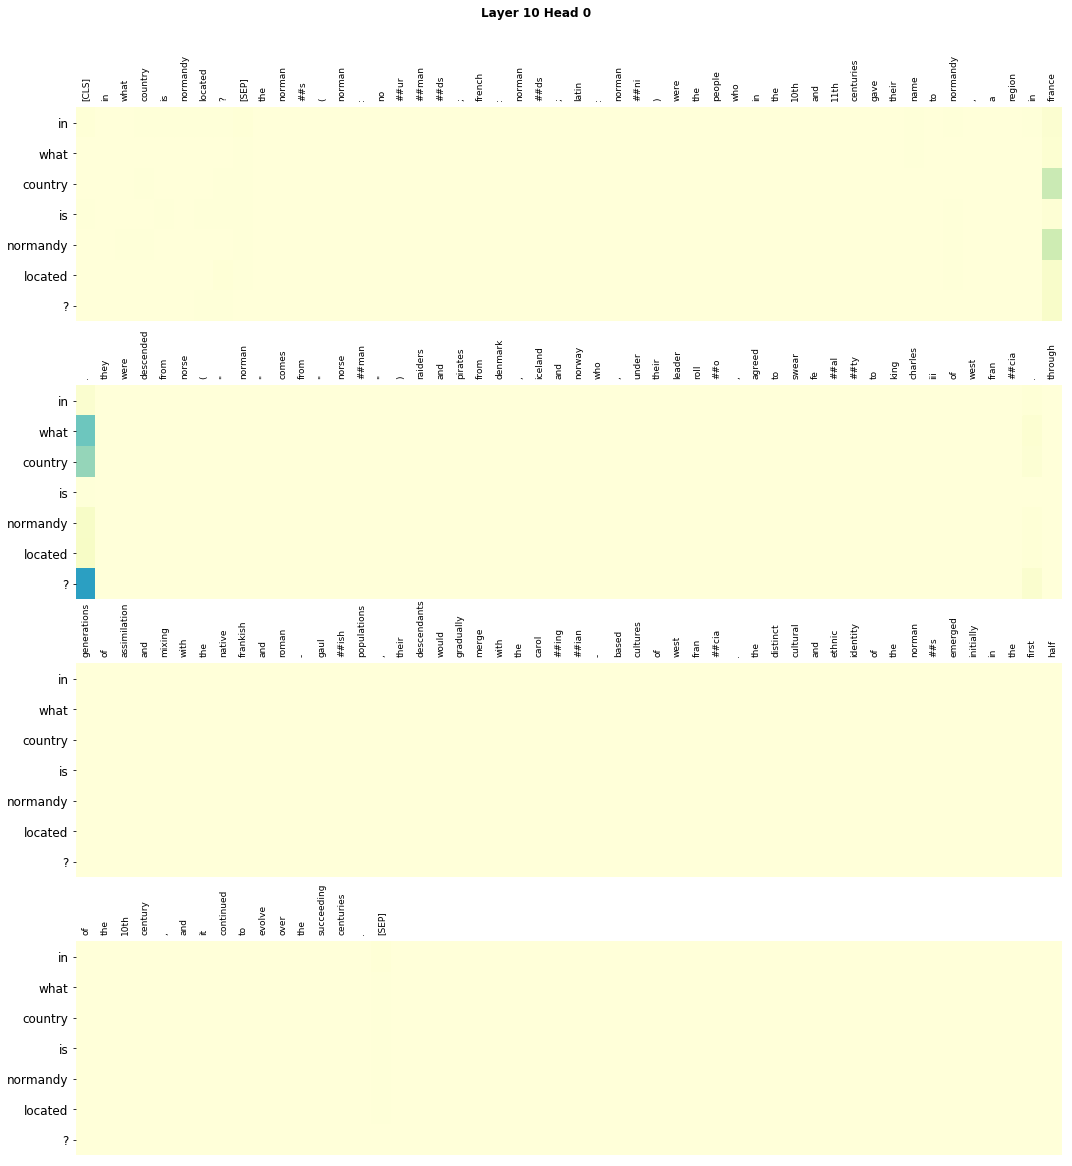

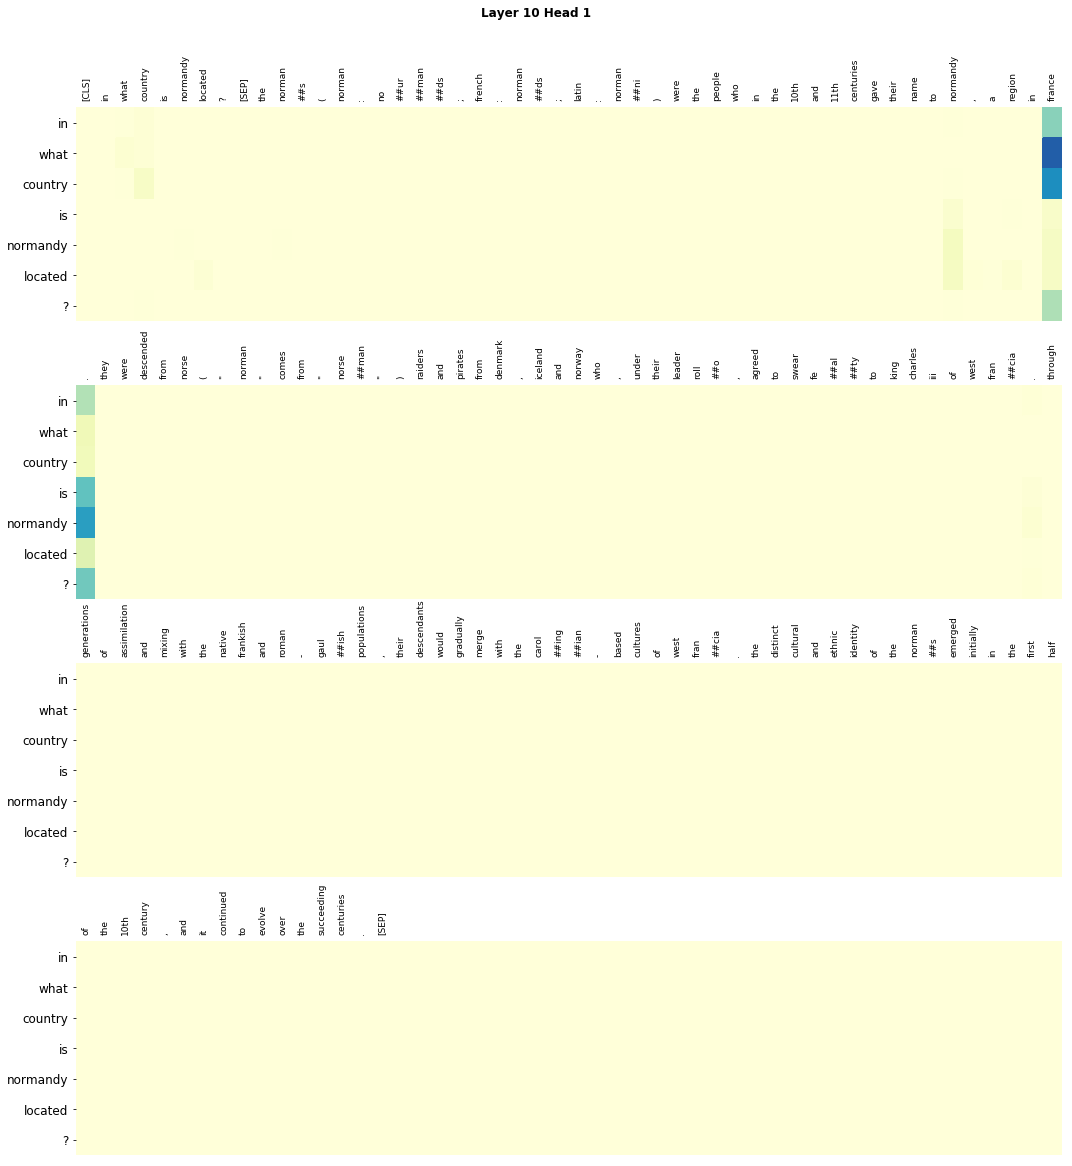

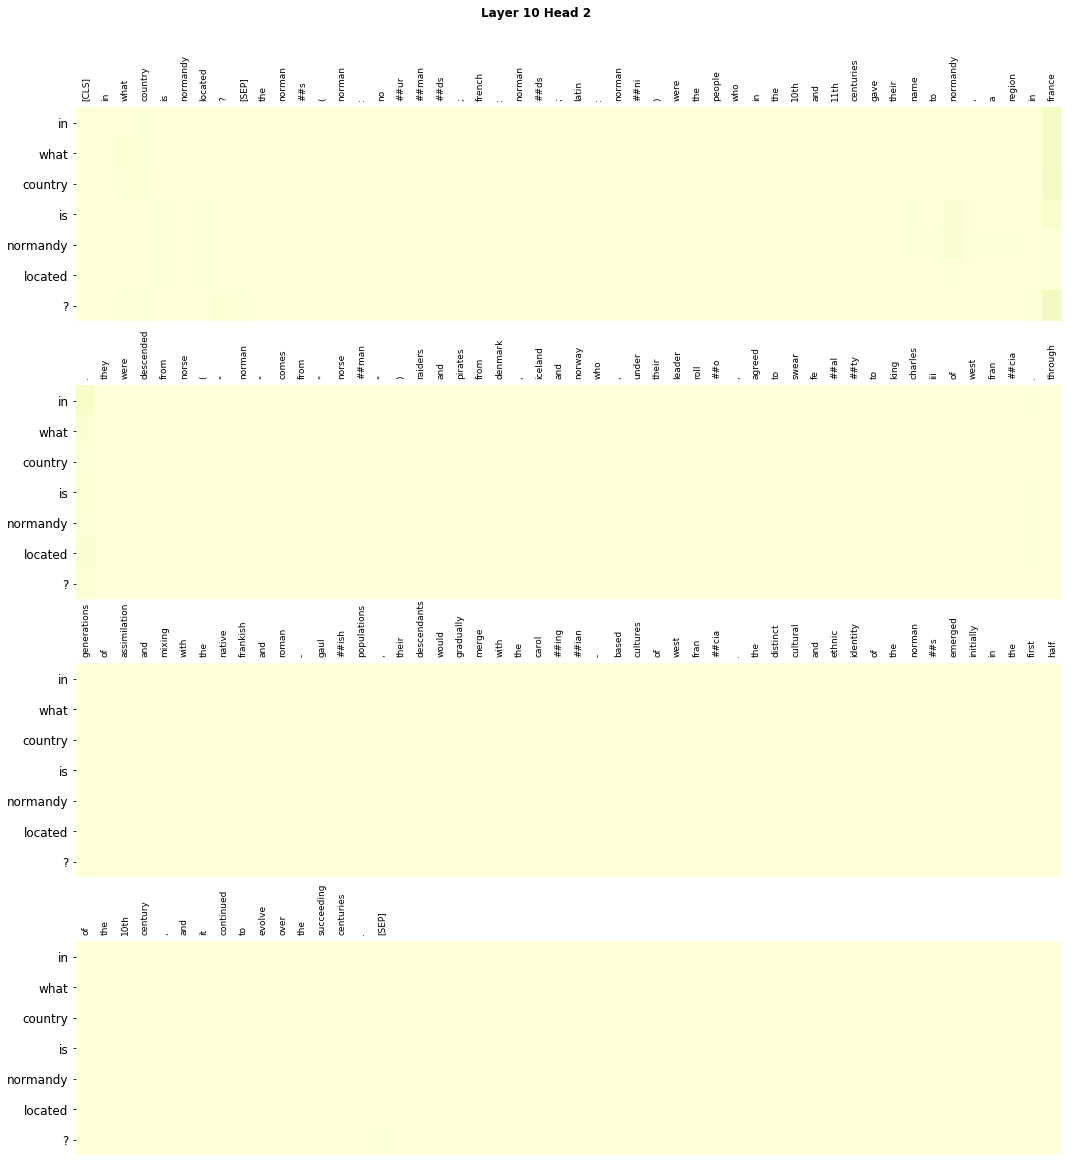

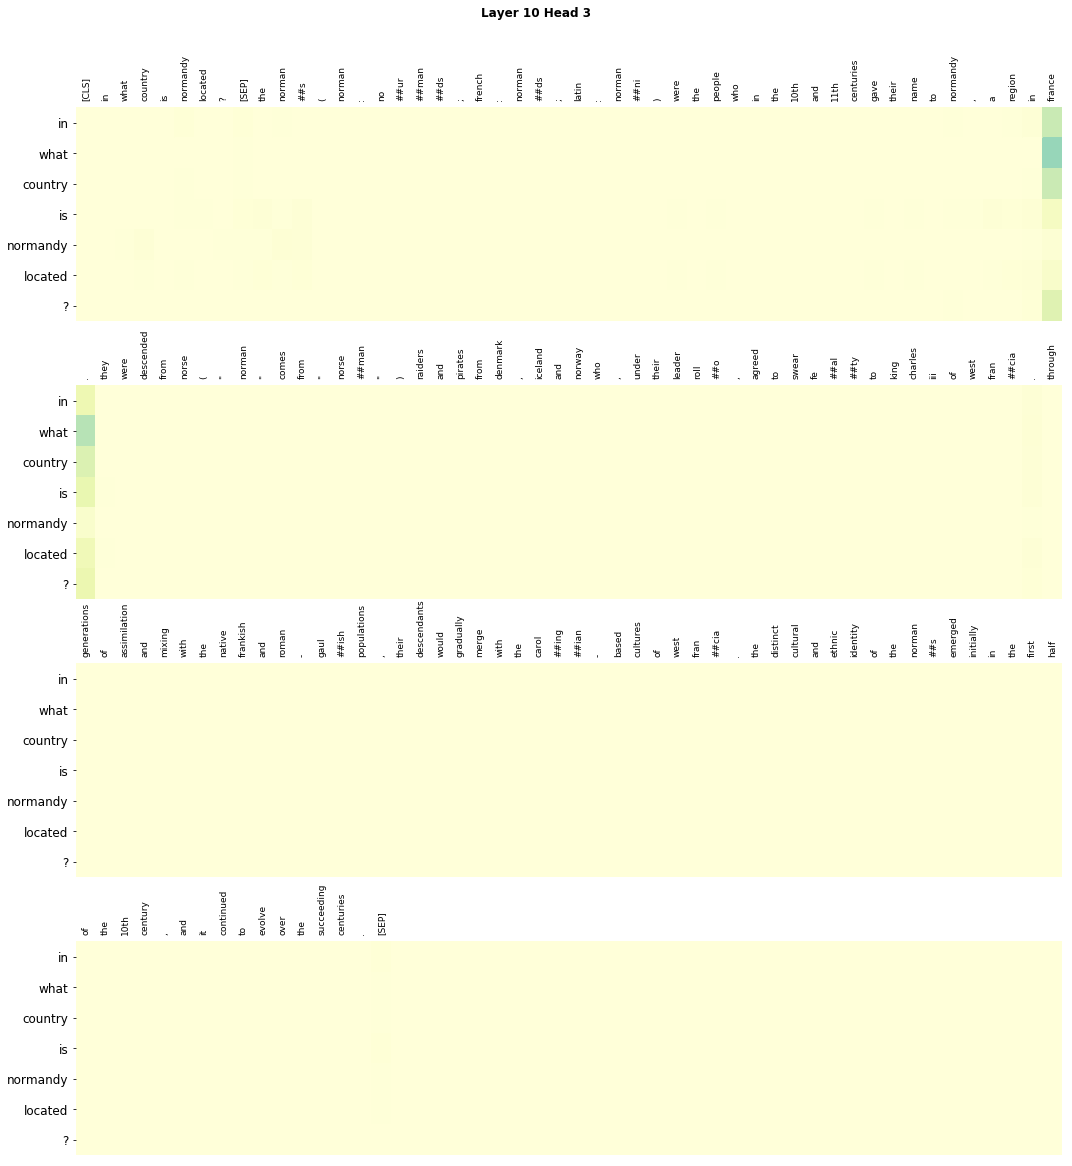

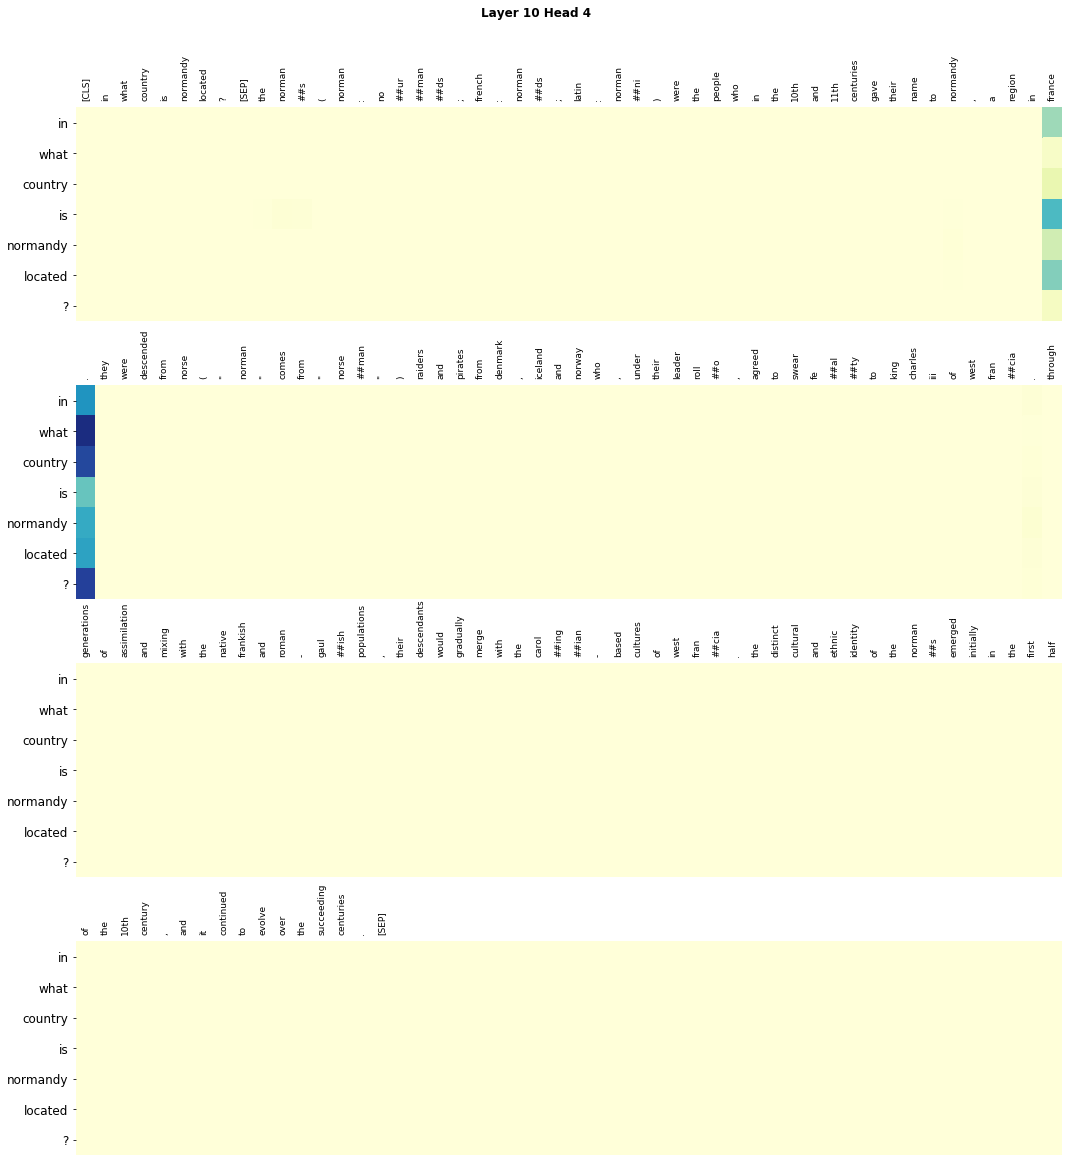

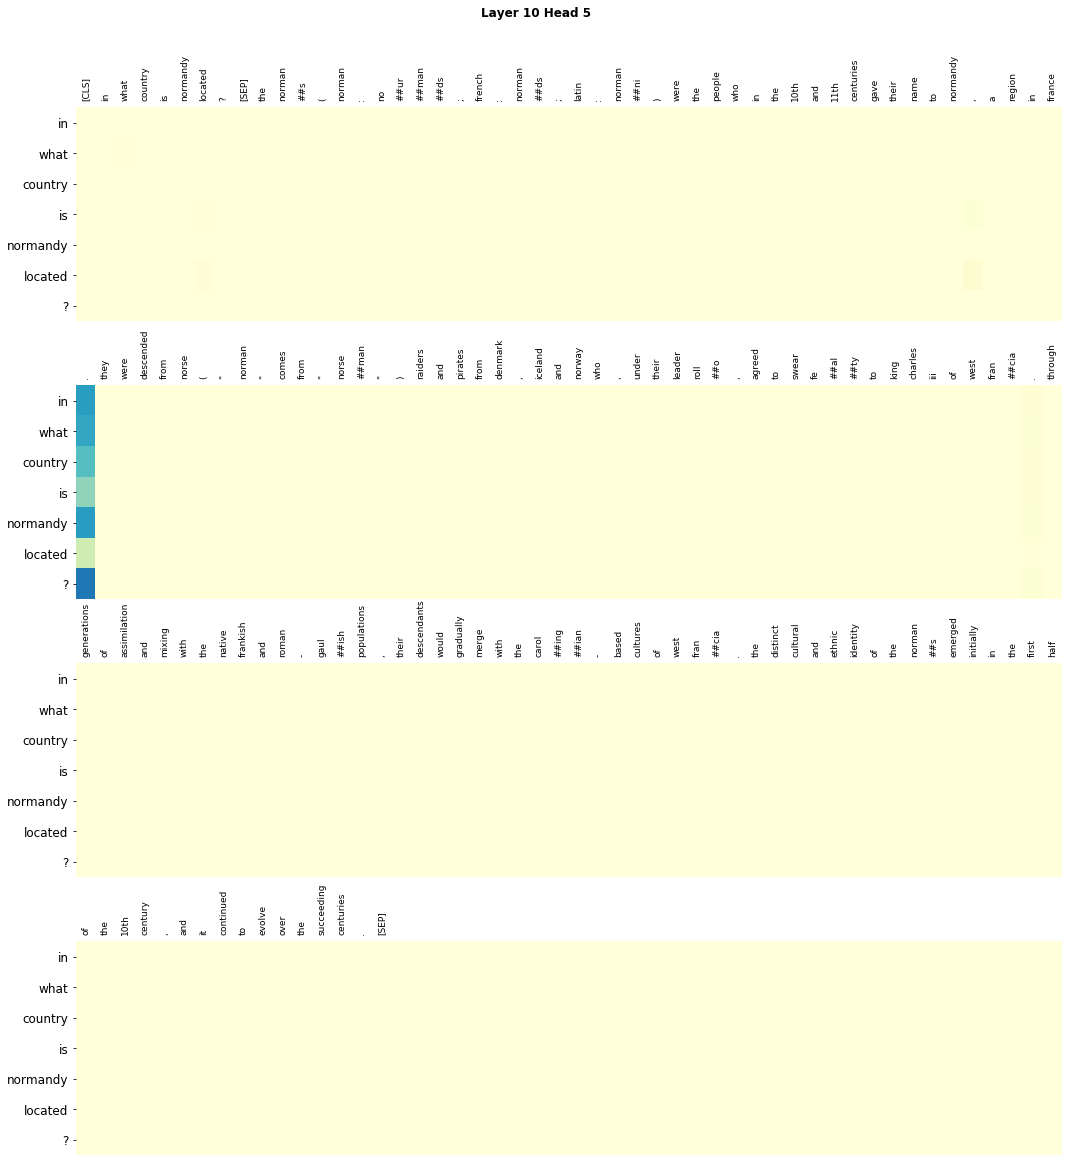

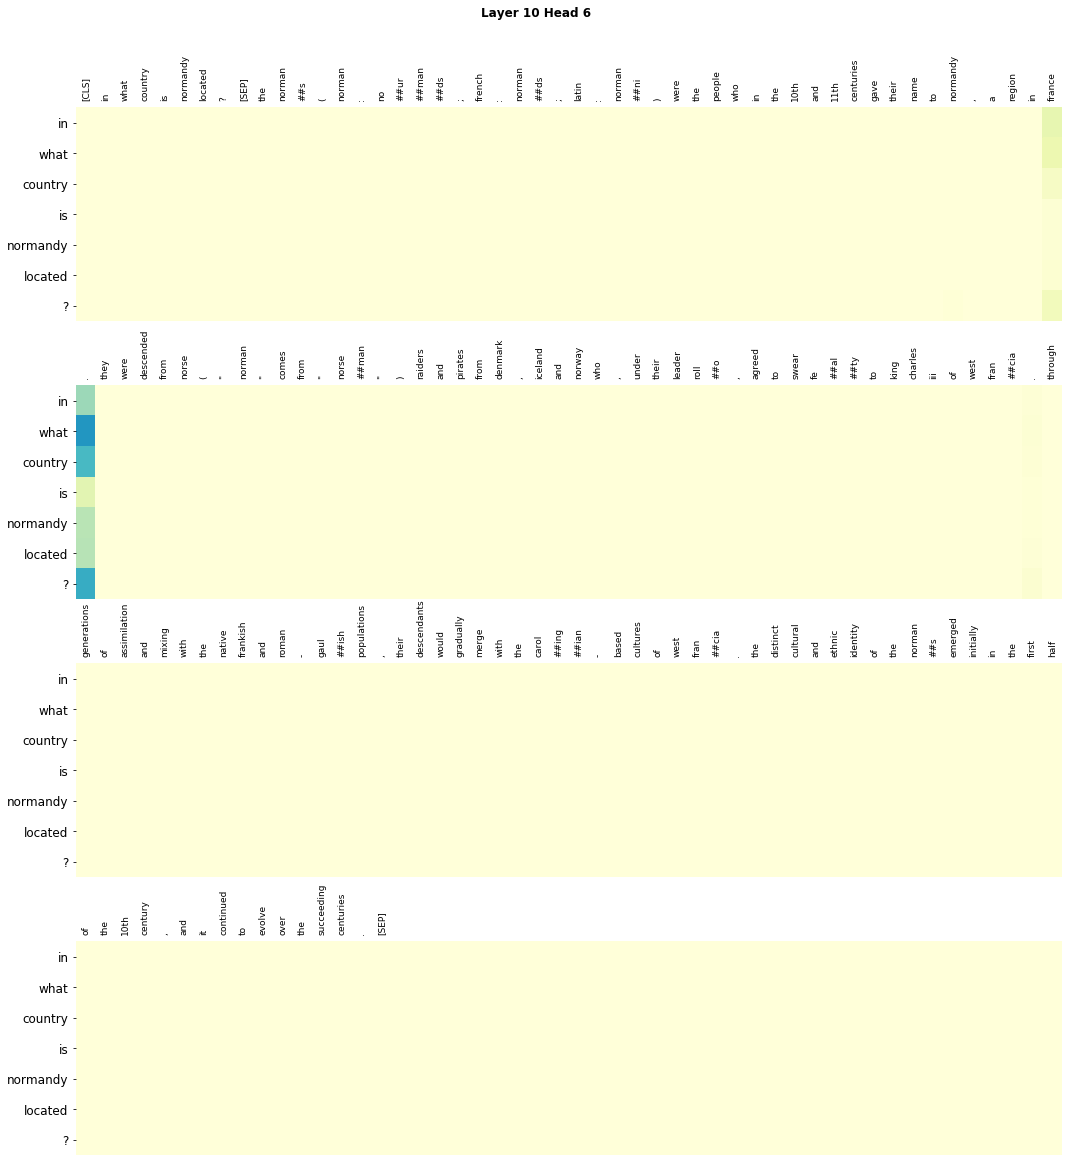

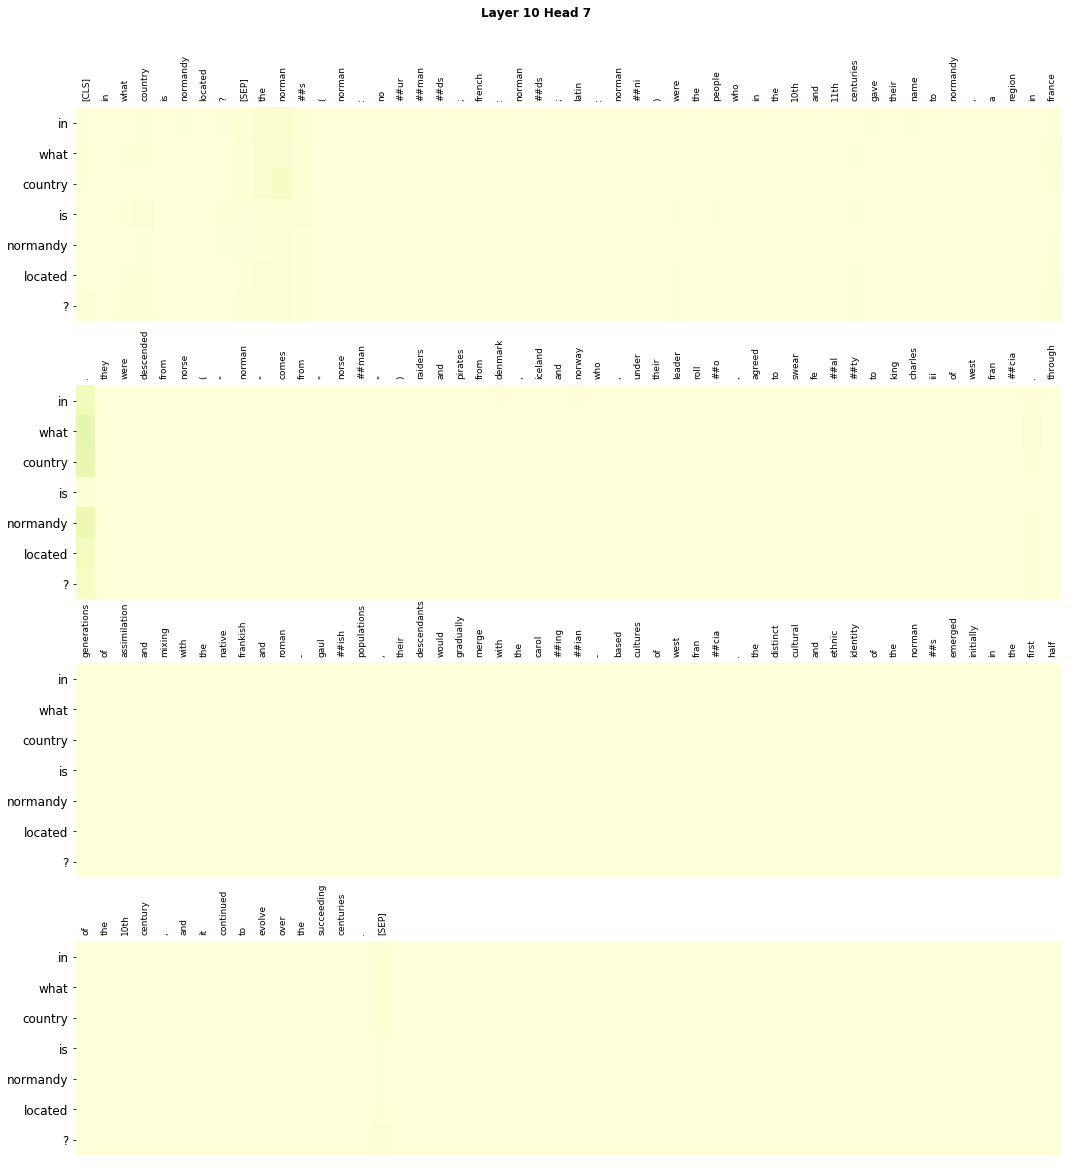

In [0]:
# Plot attention maps for all 12 Attention Heads of Layer 10
for h in range(8):
    PlotAttention(activation, layer_=10, head_=h);

In [0]:
print('Question: ', question_)
df.head()

Question:  In what country is Normandy located?


,Probability,Text
0,0.999,France
1,0.001,France.
2,0.000,"Normandy, a region in France"
3,0.000,in France
4,0.000,a region in France
